# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [50]:
import cv2

import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal
import utils

In [51]:
# switch from notebook to inline if using colab or otherwise cannot use interactive display)
%matplotlib ipympl
import matplotlib.pyplot as plt

In [52]:
datadir = "./"

im1_file = datadir + 'nutmeg.jpg'
im2_file = datadir + 'DerekPicture.jpg'

im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

#### Get Eye Points

In [53]:
# pts_im1 = utils.prompt_eye_selection(im1)
pts_im1 = np.array([[607, 290], [748, 370]]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')

In [54]:
# pts_im2 = utils.prompt_eye_selection(im2)
pts_im2 = np.array([[299,343], [439,331]]) # uncomment if entering [x, y] pts manually
plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')

In [55]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)

In [56]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

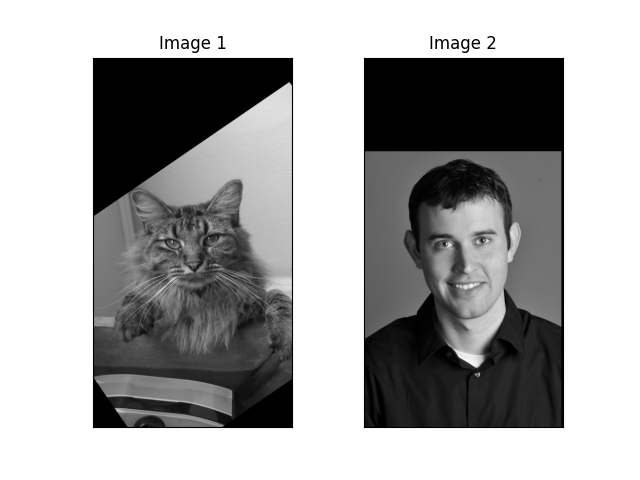

In [57]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

In [58]:
def hybridImageNPFFT(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  

    fig, ax = plt.subplots(1, 3)

    # Take FFT of image
    im2_fft = np.abs(np.fft.fftshift(np.fft.fft2(im2)))
    # Plot the spectrum
    plt_mappable = ax[0].imshow(im2_fft, norm=LogNorm(vmin=1/5))
    fig.colorbar(plt_mappable)
    print(f"fft img shape: {im2_fft.shape}")

    # Create gaussian kernel in frequency space
    ksize = int(np.ceil(sigma_low)*6+1)
    gauss_kernel = cv2.getGaussianKernel(ksize, sigma_low) # 1D kernel
    gauss_kernel = gauss_kernel*np.transpose(gauss_kernel) # 2D kernel by outer product
    gaussian_mask = gauss_kernel / np.max(gauss_kernel)
    # Pad kernel to make it same shape as fft image
    rows_to_add = im2_fft.shape[0] - gaussian_mask.shape[0]
    cols_to_add = im2_fft.shape[1] - gaussian_mask.shape[1]
    # I did +1 because the shape was one off from fft_img shape in both dimensions
    padded_gauss = np.pad(gaussian_mask, ((rows_to_add//2, rows_to_add//2 +1), (cols_to_add//2, cols_to_add//2 +1)), mode='constant', constant_values=0)
    ax[1].imshow(padded_gauss, cmap='gray') 
    print(f"padded gauss shape: {padded_gauss.shape}")
    print(f"padded middle: {padded_gauss[700][350]}")

    # Apply filter to fft_img
    # TODO ELC pick up from here, the picture output looks wrong
    # TODO ELC Maybe switch to dft from opencv2, not fft from numpy..?
    fft_filtered = im2_fft * padded_gauss
    # ax[2].imshow(fft_filtered, norm=LogNorm(vmin=1/5))

    # Undo original shift
    fft_filtered_unshifted = np.fft.ifftshift(fft_filtered)
    # Inverse the fft
    inverse_fft_filtered = np.real(np.fft.ifft2(fft_filtered_unshifted))
    ax[2].imshow(inverse_fft_filtered, cmap='gray')
    print(f"Final low-pass image shape: {padded_gauss.shape}")


In [59]:
def hybridImageDFT(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  

    fig, ax = plt.subplots(1, 3)

    ##### Take FFT of image
    im2_dft = cv2.dft(im2, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(im2_dft)

    ##### Plot the spectrum
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    # plt_mappable = ax[0].imshow(magnitude_spectrum, norm=LogNorm(vmin=1/5))
    # fig.colorbar(plt_mappable)
    print(f"dft_shift shape: {dft_shift.shape}")
    ax[0].imshow(magnitude_spectrum, cmap = 'gray')

    ##### Create gaussian kernel in spatial domain
    ksize = int(np.ceil(sigma_low)*6+1)
    gauss_kernel = cv2.getGaussianKernel(ksize, sigma_low) # 1D kernel
    gauss_kernel = gauss_kernel*np.transpose(gauss_kernel) # 2D kernel by outer product
    # Not sure I need this now
    # gaussian_mask = gauss_kernel / np.max(gauss_kernel)

    ##### Pad kernel to make it same shape as fft image
    rows_to_add = dft_shift.shape[0] - gauss_kernel.shape[0]
    cols_to_add = dft_shift.shape[1] - gauss_kernel.shape[1]
    # I did +1 because the shape was one off from fft_img shape in both dimensions
    padded_gauss = np.pad(gauss_kernel, ((rows_to_add//2, rows_to_add//2), (cols_to_add//2, cols_to_add//2)), mode='constant', constant_values=0)
    ax[1].imshow(padded_gauss, cmap='gray') 
    print(f"padded gauss shape: {padded_gauss.shape}")

    ##### FFT the kernel
    mask_dft = cv2.dft(padded_gauss, flags = cv2.DFT_COMPLEX_OUTPUT)
    mask_dft_shift = np.fft.fftshift(mask_dft)

    ##### Apply filter to fft_img
    dft_filtered = dft_shift * mask_dft_shift
    f_ishift = np.fft.ifftshift(dft_filtered)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    ax[2].imshow(img_back, cmap = 'gray')
    print(f"Final low-pass image shape: {padded_gauss.shape}")

In [60]:
def hybridImageCLOSE(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    
    # Convert to float64 for better precision during computation
    im2 = np.float64(im2)
    
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))

    ##### Take FFT of image using numpy
    im2_fft = np.fft.fft2(im2)
    im2_fft_shifted = np.fft.fftshift(im2_fft)

    ##### Plot the spectrum
    magnitude_spectrum = 20 * np.log(np.abs(im2_fft_shifted) + 1)
    ax[0].imshow(magnitude_spectrum, cmap='gray')
    ax[0].set_title('FFT Magnitude Spectrum')

    ##### Create Gaussian kernel in the spatial domain
    ksize = int(np.ceil(sigma_low) * 6 + 1)
    if ksize % 2 == 0:  # Ensure odd kernel size
        ksize += 1
        
    gauss_kernel = cv2.getGaussianKernel(ksize, sigma_low)  # 1D kernel
    gauss_kernel = gauss_kernel @ gauss_kernel.T  # 2D kernel by outer product

    ##### Create a filter the same size as the image
    rows, cols = im2.shape
    gaussian_filter = np.zeros((rows, cols), dtype=np.float64)

    # Center the kernel in the frequency domain (no need to shift in spatial domain)
    start_row = (rows - ksize) // 2
    start_col = (cols - ksize) // 2
    gaussian_filter[start_row:start_row + ksize, start_col:start_col + ksize] = gauss_kernel

    ax[1].imshow(gaussian_filter, cmap='gray')
    ax[1].set_title('Gaussian Filter (Spatial Domain)')

    # Now, we shift the kernel to the frequency domain's zero-frequency center
    # Fourier transform of the kernel
    gaussian_fft = np.fft.fft2(gaussian_filter)

    # Shift the filter in the frequency domain (this is the crucial part!)
    gaussian_fft_shifted = np.fft.fftshift(gaussian_fft)

    # Visualize the filter in the frequency domain (should be centered)
    ax[2].imshow(np.abs(gaussian_fft_shifted), cmap='gray')
    ax[2].set_title('Gaussian Filter (Frequency Domain)')

    ##### Apply filter in the frequency domain
    filtered_fft = im2_fft_shifted * gaussian_fft_shifted

    ##### Convert back to spatial domain
    filtered_fft_unshifted = np.fft.ifftshift(filtered_fft)
    img_back = np.fft.ifft2(filtered_fft_unshifted)
    img_back = np.real(img_back)  # Take only the real part
    
    # Ensure output is in reasonable range [0,1]
    img_back = np.clip(img_back, 0, 1)

    ax[3].imshow(img_back, cmap='gray', vmin=0, vmax=1)
    ax[3].set_title('Filtered Image')
    
    print(f"Original image shape: {im2.shape}")
    print(f"Gaussian kernel size: {ksize}x{ksize}")
    print(f"Filter array shape: {gaussian_filter.shape}")
    print(f"Output image range: [{img_back.min():.4f}, {img_back.max():.4f}]")
    
    plt.tight_layout()
    plt.show()
    
    return img_back



In [61]:
def hybridImageStillBadNoShift(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    
    # Convert to float64 for better precision during computation
    im2 = np.float64(im2)
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ##### Take FFT of image using numpy
    im2_fft = np.fft.fft2(im2)

    ##### Plot the spectrum
    magnitude_spectrum = 20 * np.log(np.abs(im2_fft) + 1)
    ax[0].imshow(magnitude_spectrum, cmap='gray')
    ax[0].set_title('FFT Magnitude Spectrum')

    ##### Create Gaussian kernel in the spatial domain
    ksize = int(np.ceil(sigma_low) * 6 + 1)
    if ksize % 2 == 0:  # Ensure odd kernel size
        ksize += 1
        
    gauss_kernel = cv2.getGaussianKernel(ksize, sigma_low)  # 1D kernel
    gauss_kernel = gauss_kernel @ gauss_kernel.T  # 2D kernel by outer product

    ##### Create a filter the same size as the image
    rows, cols = im2.shape
    gaussian_filter = np.zeros((rows, cols), dtype=np.float64)

    # Center the kernel in the spatial domain
    start_row = (rows - ksize) // 2
    start_col = (cols - ksize) // 2
    gaussian_filter[start_row:start_row + ksize, start_col:start_col + ksize] = gauss_kernel

    # Debugging: Check kernel dimensions
    print(f"Spatial Gaussian Filter Shape: {gaussian_filter.shape}")
    
    ax[1].imshow(gaussian_filter, cmap='gray')
    ax[1].set_title('Gaussian Filter (Spatial Domain)')

    ##### Fourier transform of the kernel (Gaussian filter)
    gaussian_fft = np.fft.fft2(gaussian_filter)
    
    # Debugging: Check the shape of the filter FFT
    print(f"Shape of Gaussian Filter FFT: {gaussian_fft.shape}")
    
    # Apply the filter directly in the frequency domain (no shift)
    filtered_fft = im2_fft * gaussian_fft

    ##### Convert back to spatial domain (Inverse FFT without shifting)
    img_back = np.fft.ifft2(filtered_fft)
    
    # Take only real part (the imaginary part should be very close to zero)
    img_back = np.real(img_back)

    # Ensure output is in reasonable range [0,1]
    img_back = np.clip(img_back, 0, 1)

    ax[2].imshow(img_back, cmap='gray', vmin=0, vmax=1)
    ax[2].set_title('Filtered Image')
    
    print(f"Original image shape: {im2.shape}")
    print(f"Gaussian kernel size: {ksize}x{ksize}")
    print(f"Output image range: [{img_back.min():.4f}, {img_back.max():.4f}]")
    
    plt.tight_layout()
    plt.show()
    
    return img_back


In [107]:
def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  
    
    fig, ax = plt.subplots(1, 5, figsize=(10, 5))

    ##### Take FFT of image using numpy
    im2_fft = np.fft.fft2(im2)
    im2_fft_shifted = np.fft.fftshift(im2_fft)

    ##### Plot the spectrum
    magnitude_spectrum = 20 * np.log(np.abs(im2_fft_shifted) + 1)
    ax[0].imshow(magnitude_spectrum, cmap='gray')
    ax[0].set_title('FFT Magnitude Spectrum of Image')

    ##### Create Gaussian kernel just like if this was spatial domain
    ksize = int(np.ceil(sigma_low) * 6 + 1)
    if ksize % 2 == 0:  # Ensure odd kernel size
        ksize += 1
        
    gauss_kernel = cv2.getGaussianKernel(ksize, sigma_low)  # 1D kernel
    gauss_kernel = gauss_kernel @ gauss_kernel.T  # 2D kernel by outer product
    print(f"Kernel min max: {np.min(gauss_kernel)}, {np.max(gauss_kernel)}")

    ##### Pad kernel to be same size as img
    rows, cols = im2.shape
    gaussian_filter = np.zeros((rows, cols), dtype=np.float32)

    # Center the kernel in the frequency domain
    start_row = (rows - ksize) // 2
    start_col = (cols - ksize) // 2
    gaussian_filter[start_row:start_row + ksize, start_col:start_col + ksize] = gauss_kernel
    # Upscale the filter to be from 0 to 1
    gauss_norm_filte = gaussian_filter / np.max(gaussian_filter)
    print(f"gauss_norm_filte min max: {np.min(gauss_norm_filte)}, {np.max(gauss_norm_filte)}")

    ax[1].imshow(gauss_norm_filte, cmap='gray')
    ax[1].set_title('Gaussian Filter')

    ##### Create inverted gauss filter from regular gauss filter
    high_p_filter = np.ones((rows, cols), dtype=np.float32)
    high_p_filter -= gauss_norm_filte

    ax[2].imshow(high_p_filter, cmap='gray')
    ax[2].set_title('Reverse Gauss Filter')

    # Apply the filter directly in the frequency domain (no shift)
    low_filtered_fft = im2_fft_shifted * gauss_norm_filte
    high_filtered_fft = im2_fft_shifted * high_p_filter

    ##### Convert back to spatial domain (Inverse FFT without shifting)
    # Take only real part (the imaginary part should be very close to zero)
    low_img_back = np.real(np.fft.ifft2(np.fft.ifftshift(low_filtered_fft)))
    high_img_back = np.real(np.fft.ifft2(np.fft.ifftshift(high_filtered_fft)))

    # Print Low
    print(f"low image range: [{low_img_back.min():.4f}, {low_img_back.max():.4f}]")
    
    # Final visualization
    ax[3].imshow(low_img_back, cmap='gray', vmin=0, vmax=1)
    ax[3].set_title('low-pass')

    ### Print High
    print(f"high image range: [{high_img_back.min():.4f}, {high_img_back.max():.4f}]")
    
    # Final visualization
    ax[4].imshow(high_img_back, cmap='gray', vmin=0, vmax=1)
    ax[4].set_title('high-pass')

    plt.show()
    
    return low_img_back # TODO ELC replace



Kernel min max: 4.934803200539452e-08, 0.00039987124500038824
gauss_norm_filte min max: 0.0, 1.0
low image range: [-0.0001, 0.8622]
high image range: [-0.4335, 0.6674]


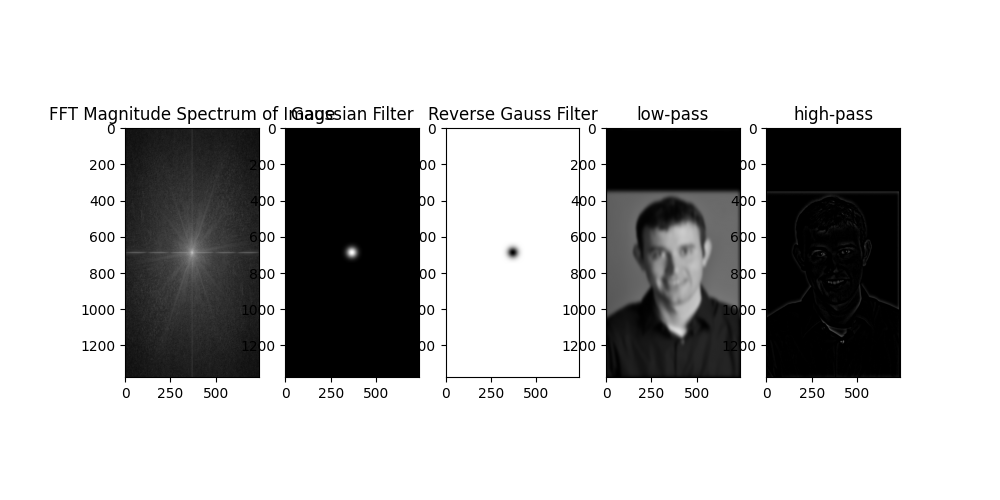

In [108]:
sigma_low = 20 # choose parameters that work for your images
sigma_high = 20

im_hybrid = hybridImage(im1, im2, sigma_low, sigma_high)


In [ ]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

#### Color enhancement 

#### Color shift